In [1]:
%matplotlib inline
# %matplotlib notebook
from IPython.display import Audio, display
import pandas as pd
from matplotlib import pyplot as plt
import numpy as np
import os
from shutil import copy, rmtree
from os.path import join as jp
from tqdm import tqdm
import pickle
from scipy.io import wavfile as wf
from time import time, sleep
from input_data import prepare_words_list
from glob import glob
import hashlib
from classes import get_classes, get_int2label, get_label2int
from keras.layers import Input, Lambda
from model import prepare_model_settings, relu6
from keras.applications.mobilenet import DepthwiseConv2D
from keras.models import Model
from keras import backend as K
import tensorflow as tf
from tensorflow.contrib.framework.python.ops import audio_ops as contrib_audio
from tensorflow.python.ops import io_ops
from keras.layers import Input, Conv1D, Reshape
from keras.models import Model, load_model

def pad_crop(data, desired_size=16000):
    data_len = len(data)
    if data_len < desired_size:
        missing = desired_size - data_len
        data = np.pad(data, (missing, 0), mode='constant')
    else:
        data = data[:desired_size]
    return data

def float_audio(x, sample_rate=16000, autoplay=False):
    # avoid Audio normalizing the data
    data = np.int16(x * 32768)
    fn = '/tmp/%s.wav' % data[:5]
    wf.write(fn, sample_rate, data)
    display(Audio(filename=fn, rate=sample_rate, autoplay=autoplay))

def plot_audio(data, sample_rate=16000, normed=False):
    if not normed:
        data = np.float32(data) / 32768
    plt.figure()
    plt.plot(np.arange(sample_rate), data)
    plt.axis([0, sample_rate, -1, 1])
    
def center_pad(data, desired_size=16000):
    missing = desired_size - len(data)
    pad_left = missing // 2
    pad_right = missing - pad_left
    padded_data = np.pad(data, (pad_left, pad_right), mode='constant')
    return padded_data

def random_crop(data, desired_size=16000):
    start = np.random.randint(len(data) - desired_size)
    return data[start: start + desired_size]

def normalized_read(fn, desired_size=16000):
    rate, data = wf.read(fn)
    data = np.float32(data) / 32768
    assert rate == 16000
    if len(data) < desired_size:
        data = center_pad(data, desired_size=desired_size)
    elif len(data) > desired_size:
        data = random_crop(data, desired_size=desired_size)
    return data

def md5(fname):
    hash_md5 = hashlib.md5()
    with open(fname, "rb") as f:
        for chunk in iter(lambda: f.read(4096), b""):
            hash_md5.update(chunk)
    return hash_md5.hexdigest()

Using TensorFlow backend.


In [ ]:
sub1 = pd.read_csv('submission_033b.csv')  # 87% PLB
sub2 = pd.read_csv('submission_017.csv')  # 87% PLB
sub3 = pd.read_csv('submission_018.csv')  # 86% PLB

In [ ]:
# check where all three disagree
unequal = ((sub1.label != sub2.label) & (sub1.label != sub3.label))
print("%d of %d are unequal" % (unequal.sum(), sub1.shape[0]))

## Display where classifiers disagree
These samples are acutally quite hard!

In [ ]:
TEST_DIR = 'data/test/audio'
disp_count = 0
for i in range(len(unequal)):
    if disp_count > 5:
        break
    if unequal[i] and np.random.rand() > 0.99:
        fn = os.path.join(TEST_DIR, sub1.loc[i, 'fname'])
        print(fn, ': ', sub1.loc[i, 'label'], " vs ", sub2.loc[i, 'label'])
        display(Audio(fn, autoplay=True))
        sleep(1)
        disp_count += 1

In [ ]:
# save these "hard" ones
for i in tqdm(range(len(unequal))):
    if unequal[i]:
        bn = sub1.loc[i, 'fname']
        src_fn = os.path.join('data/test/audio', bn)
        dst_fn = os.path.join('data/pseudo/audio/unknown', bn)
        copy(src_fn, dst_fn)
# when using as pseudo labels remove 'silence'! (e.g. ls *.wav | grep -v silence)

## Show (predicted) test data distribution
### Note that during training silence prob was 10%

In [ ]:
def show_bar(submission):
    counts = []
    for label_name in submission.label.unique():
        label_count = (submission.label == label_name).sum()
        percent = (label_count / num_total) * 100.0
        counts.append((label_name, percent))
    print(counts)
    plt.bar(range(len(counts)), [c[-1] for c in counts])
    _ = plt.xticks(range(len(counts)), [c[0] for c in counts])
    plt.grid('on')
    plt.xlabel('Label names')
    plt.ylabel('Precentage [%]')

In [ ]:
show_bar(sub1)

# Compress and decompress using mu-law

In [ ]:
def load_wav(fn):
    rate, data = wf.read(fn)
    assert rate == 16000
    data = data / 32768
    missing = 16000 - len(data)
    data = np.pad(data, (missing, 0), mode='constant')
    return data


def compress(x, mu=255):
    assert x.min() >= -1 and x.max() <= 1
    compressed = np.sign(x) * np.log10(1.0 + mu * np.abs(x)) / np.log10(1.0 + mu)
    return compressed

def decompress(x, mu=255):
    assert x.min() >= -1 and x.max() <= 1
    decompressed= np.sign(x) * (1.0 / mu) * (np.power(1.0 + x, np.abs(x)) - 1.0)
    return decompressed

In [ ]:
up_sample = load_wav('data/test/audio/clip_001204892.wav')
float_audio(up_sample)
c = compress(up_sample)
d = decompress(c)
float_audio(d)

In [ ]:
display(Audio(data=np.int16(up_sample  * 32768), rate=16000))

### Use average pooling to reduce signal size

In [ ]:
from keras.models import Model
from keras.layers import AveragePooling1D, Input, Reshape
def avg_model(sample_rate=16000):
    input_layer = Input([sample_rate])
    x = input_layer
    x = Reshape([-1, 1])(x)
    x = AveragePooling1D(2)(x)
    return Model(input_layer, x)

model = avg_model()
out = model.predict([up_sample.reshape((1, -1))]).squeeze()


In [ ]:
plt.figure()
plt.title('Orginal')
plt.plot(up_sample)
plt.figure()
plt.title('Subsamples')
plt.plot(out)

In [ ]:
float_audio(out, sample_rate=len(out))

# How is the padding handeled by decode_wav?

In [ ]:
from tensorflow.contrib.framework.python.ops import audio_ops as contrib_audio
from tensorflow.python.ops import io_ops

wav_filename_placeholder = tf.placeholder(tf.string, [])
wav_loader = io_ops.read_file(wav_filename_placeholder)
wav_decoder = contrib_audio.decode_wav(
    wav_loader, desired_channels=1)
fns = sorted(glob('data/train/audio/go/*.wav'))
short_fn = ''
with tf.Session() as sess:
    for fn in fns:
        out = sess.run(wav_decoder.audio,
                       {wav_filename_placeholder: fn_val})
        if out.shape[0] != 16000:
            short_fn = fn
            print(fn)
            break
print(out.shape)

In [ ]:
display(Audio(short_fn, autoplay=True))
sleep(1)
float_audio(out, autoplay=True)

# Check how many samples are shorter than 1s

In [ ]:
from glob import glob
from tqdm import tqdm
train_fns = sorted(glob('data/train/audio/*/*.wav'))

In [ ]:
def load_wav(fn):
    rate, data = wf.read(fn)
    assert rate == 16000
    return data

short_count = 0
for fn in tqdm(train_fns):
    data = load_wav(fn)
    if len(data) != 16000:
        short_count += 1
print("Short: ", short_count)
print("All: ", len(train_fns))

# Visualize augmented training data

In [ ]:
from __future__ import division, print_function
from keras import backend as K
from keras.callbacks import ModelCheckpoint, LearningRateScheduler
from keras.callbacks import TensorBoard
from callbacks import ConfusionMatrixCallback
from model import speech_model, prepare_model_settings
from input_data import AudioProcessor, prepare_words_list
from classes import get_classes
from IPython import embed  # noqa

In [ ]:
def data_gen(audio_processor, sess,
             batch_size=128,
             background_frequency=0.5, background_volume_range=0.2,
             foreground_frequency=0.5, foreground_volume_range=0.2,
             time_shift=(100.0 * 16000.0) / 1000,
             mode='validation'):
    offset = 0
    if mode != 'training':
        background_frequency = 0.0
        background_volume_range = 0.0
        foreground_frequency = 0.0
        foreground_volume_range = 0.0
        time_shift = 0
    while True:
        X, y = audio_processor.get_data(
            how_many=batch_size, offset=0 if mode == 'training' else offset,
            background_frequency=background_frequency,
            background_volume_range=background_volume_range,
            foreground_frequency=foreground_frequency,
            foreground_volume_range=foreground_volume_range,
            time_shift=time_shift, mode=mode, sess=sess)
        offset += batch_size
        if offset > ap.set_size(mode) - batch_size:
              offset = 0
        yield X, y

In [ ]:
sess = K.get_session()
data_dirs = ['data/train/audio']
add_pseudo = True
if add_pseudo:
    data_dirs.append('data/pseudo/audio')
compute_mfcc = False
sample_rate = 16000
batch_size = 100
classes = get_classes(wanted_only=False)
model_settings = prepare_model_settings(
  label_count=len(prepare_words_list(classes)), sample_rate=sample_rate,
  clip_duration_ms=1000, window_size_ms=30.0, window_stride_ms=10.0,
  dct_coefficient_count=40)
ap = AudioProcessor(
  data_dirs=data_dirs,
  silence_percentage=10.0,
  unknown_percentage=7.0,
  wanted_words=classes,
  validation_percentage=10.0,
  testing_percentage=0.0,
  model_settings=model_settings,
  compute_mfcc=compute_mfcc)
train_gen = data_gen(ap, sess, batch_size=batch_size, mode='training')
val_gen = data_gen(ap, sess, batch_size=batch_size, mode='validation')

In [ ]:
ap.summary()

In [ ]:
disp_count = 0
while True:
    if disp_count > 5:
        break
    X, y = next(train_gen)
    for i in range(X.shape[0]):
        if y[i].argmax() == 10:
            sample = X[i, :].squeeze()
            float_audio(sample, autoplay=True)
            sleep(1)
            disp_count += 1
            # plt.figure()
            # plt.axis([0, 16000, -1, 1])
            # plt.plot(sample)

# Create pseudo labels from consistent predictions
### [old pseudo]: Sub1: 84% PLB, Sub2: 84% PLB, Sub3: 82% PLB
### Sub1: 87% PLB, Sub2: 87% PLB, Sub3: 86% PLB

In [ ]:
sub1 = pd.read_csv('submission_033b_all_labels.csv')  # 87% PLB
sub2 = pd.read_csv('submission_017_all_labels.csv')  # 87% PLB
sub3 = pd.read_csv('submission_018_all_labels.csv')  # 86% PLB

In [ ]:
consistend = ((sub1.label == sub2.label) & (sub1.label == sub3.label))
print("All: ", sub1.shape[0], " consistend: ", consistend.sum())

In [ ]:
for i in tqdm(range(sub1.shape[0])):
    fn = sub1.loc[i, 'fname']
    if fn != sub2.loc[i, 'fname'] or fn != sub3.loc[i, 'fname']:
        print("Fatal error")
        break
    if consistend[i]:
        label = sub1.loc[i, 'label']
        dst_fn = jp('data', 'pseudo', 'audio', label, fn)
        src_fn = jp('data', 'test', 'audio', fn)
        copy(src_fn, dst_fn, follow_symlinks=False)

In [ ]:
print()

# Listen to submission

In [ ]:
words = get_classes(wanted_only=False, extend_reversed=True)
[w for w in words if 'b' in w]

In [ ]:
sub = pd.read_csv('submission_046_all_labels.csv')
label2int = get_label2int(wanted_only=True)
disp_count = 0
for i in reversed(range(sub.shape[0])):
    if disp_count >= 10:
        break
    fn = jp('data', 'test', 'audio', sub.loc[i, 'fname'])
    label = sub.loc[i, 'label']
    if label == 'off' and np.random.rand() > 0.99:
        print(label)
        display(Audio(fn, autoplay=True))
        sleep(1)
        disp_count += 1

In [ ]:
?float_audio

In [ ]:
np.random.seed(5)
sub = pd.read_csv('submission_034_all_labels.csv')
label2int = get_label2int(wanted_only=True)
disp_count = 0
for i in reversed(range(sub.shape[0])):
    if disp_count >= 2:
        break
    label = sub.loc[i, 'label']
    if label == 'silence' and np.random.rand() > 0.999:
        fn = jp('data', 'test', 'audio', sub.loc[i, 'fname'])
        rate, data = wf.read(fn)
        data = np.float32(data) / 32767
        # data = np.sqrt(data) + 0.5
        data = 10 ** (data) - 1.0
        plot_audio(data, normed=True)
        print(fn, label)
        float_audio(data, autoplay=True)
        sleep(1)
        disp_count += 1

# Listen to submission with probs

In [ ]:
print("Wanted: ", get_classes(wanted_only=True))
print("All: ", get_classes(wanted_only=False))

In [ ]:
sub = pd.read_csv('prob_ensemble_002_all_labels_probs.csv')
label2int = get_label2int(wanted_only=False)
disp_count = 0
for i in reversed(range(sub.shape[0])):
    if disp_count >= 5:
        break
    fn = jp('data', 'test', 'audio', sub.loc[i, 'fname'])
    label = sub.loc[i, 'label']
    if label == 'unknown' and np.random.rand() > 0.99:
        print(label)
        probs = sub.loc[i, label2int.keys()]
        plt.figure()
        plt.title(str(disp_count))
        plt.bar(range(len(probs)), probs)
        plt.axis([0, len(probs), 0, 1])
        plt.xticks(range(len(probs)), label2int.keys(), rotation='vertical')
        display(Audio(fn, autoplay=True))
        sleep(1)
        disp_count += 1

# Correct broken submission

In [ ]:
sub_broken = pd.read_csv('submission_012.csv')
sub_all = pd.read_csv('submission_012_all_labels.csv')
sub_broken.loc[(sub_all.label == 'unknown').values, 'label'] = 'silence'
sub_broken.to_csv('submission_012_corrected.csv', index=False)

In [ ]:
sub = pd.read_csv('submission_012_corrected.csv')
disp_count = 0
for i in range(sub.shape[0]):
    if disp_count >= 10:
        break
    fn = jp('data', 'test', 'audio', sub.loc[i, 'fname'])
    label = sub.loc[i, 'label']
    if label != 'unknown' and np.random.rand() > 0.9:
        print(label)
        display(Audio(fn, autoplay=True))
        sleep(1)
        disp_count += 1

In [ ]:
sub = pd.read_csv('submission_012_all_labels.csv')
counts = sub.label.value_counts()
percent_counts = counts.apply(lambda x: np.round(100.0 * (x / sub.shape[0])))
# print(counts)
print(percent_counts)

# Check what the generators are producing

In [ ]:
from keras import backend as K
from keras.callbacks import ModelCheckpoint, LearningRateScheduler
from keras.callbacks import TensorBoard
from model import speech_model, prepare_model_settings
from input_data import AudioProcessor, prepare_words_list
from classes import get_classes


def data_gen(audio_processor, sess,
             batch_size=128,
             background_frequency=0.5, background_volume_range=0.2,
             foreground_frequency=1.0, foreground_volume_range=3.0,
             time_shift=(100.0 * 16000.0) / 1000,
             mode='validation'):
    offset = 0
    if mode != 'training':
        background_frequency = 0.0
        background_volume_range = 0.0
        foreground_frequency = 0.0
        foreground_volume_range = 0.0
        time_shift = 0

    while True:
        X, y = audio_processor.get_data(
            how_many=batch_size, offset=0 if mode == 'training' else offset,
            background_frequency=background_frequency,
            background_volume_range=background_volume_range,
            foreground_frequency=foreground_frequency,
            foreground_volume_range=foreground_volume_range,
            time_shift=time_shift, mode=mode, sess=sess)
        offset += batch_size
        if offset > ap.set_size(mode) - batch_size:
            offset = 0
        yield X, y


sess = K.get_session()
data_dirs = ['data/train/audio']
add_pseudo = False
if add_pseudo:
    data_dirs.append('data/pseudo/audio')
compute_mfcc = False
sample_rate = 16000
batch_size = 64
classes = get_classes(wanted_only=False)
model_settings = prepare_model_settings(
  label_count=len(prepare_words_list(classes)), sample_rate=sample_rate,
  clip_duration_ms=1000, window_size_ms=30.0, window_stride_ms=10.0,
  dct_coefficient_count=40)
ap = AudioProcessor(
  data_dirs=data_dirs,
  silence_percentage=15.0,
  unknown_percentage=7.0,
  wanted_words=classes,
  validation_percentage=10.0,
  testing_percentage=0.0,
  model_settings=model_settings,
  compute_mfcc=compute_mfcc)
train_gen = data_gen(ap, sess, batch_size=batch_size, mode='training')
val_gen = data_gen(ap, sess, batch_size=batch_size, mode='validation')

In [ ]:
ap.summary()

In [ ]:
wanted_words = get_classes(wanted_only=True)
print(wanted_words)
labels2int = {v: k for k, v in ap.word_to_index.items()}

In [ ]:
!rm -rf data/train/audio/_silence_
!mkdir data/train/audio/_silence_

In [ ]:
# save silence samples to '_silence_'
disp_count = 0
for i in range(100):
    print(disp_count)
    if disp_count > 100:
        break
    X, y = next(train_gen)
    y = y.argmax(axis=-1)
    for j in range(len(y)):
        if y[j] == 0:
            print(labels2int[y[j]])
            out_fn = jp('data/train/audio/_silence_/%05d.wav' % disp_count)
            data = np.int16(X[j, :] * 32768)
            wf.write(out_fn, 16000, data)
            # float_audio(X[j, :], autoplay=True)
            # sleep(1)
            disp_count += 1

### Load model and check where we go wrong in the validation set

In [ ]:
model = speech_model(
  'conv_1d_time',
  model_settings['fingerprint_size'] if compute_mfcc else sample_rate,
  num_classes=model_settings['label_count'])
model.load_weights('checkpoints_014/ep-039-loss-0.173.hdf5')
disp_count = 0
for i in range(ap.set_size('validation') // batch_size):
    if disp_count >= 10:
        break
    X, y_true = next(val_gen)
    y_true = y_true.argmax(axis=-1)
    y_pred = model.predict(X).argmax(axis=-1)
    for j in range(len(y_true)):
        if y_true[j] != y_pred[j] and np.random.rand() > 0.5:
            l_true = labels2int[y_true[j]]
            l_pred = labels2int[y_pred[j]]
            print("Pred: %s, Actual: %s" % (l_pred, l_true))
            float_audio(X[j, :], autoplay=True)
            sleep(1)
            disp_count += 1

# Create "unknown" words
### Just reverse some of the unwanted words. Reversing the wanted words might actually cause some problems when using global pooling in the end?

In [ ]:
print(exclude_words)

In [ ]:
wanted_words = get_classes(wanted_only=True)
# wow reversed is wow! one reversed sounds like no!
# dog vs go :P
exclude_words = wanted_words + ['_background_noise_', 'wow', 'one', 'dog']

In [ ]:
fns = sorted(glob(jp('data', 'train', 'audio', '*', '*.wav')))
print(len(fns))
fns = [fn for fn in fns if fn.split('/')[-2] not in exclude_words]
print(len(fns))

In [ ]:
new_classes = list(set([fn.split('/')[-2] for fn in fns]))
# new_classes.remove('_silence_')
new_classes = ['new_' + new_class[::-1] for new_class in new_classes]
print(new_classes)
for new_class in new_classes:
    new_dir = jp('data/train/audio', new_class)
    if os.path.exists(new_dir):
        rmtree(new_dir)
    os.mkdir(new_dir)
    print("created %s" % new_dir)

In [ ]:
np.random.shuffle(fns)
# fn_selection = np.random.choice(fns, size=5000, replace=False)
fn_selection = fns

In [ ]:
# there (often) 5 times the same speaker said the same word
# 
# ./eight/5fadb538_nohash_4.wav
# ./eight/5fadb538_nohash_3.wav
# ./eight/5fadb538_nohash_2.wav
# ./eight/5fadb538_nohash_1.wav
# ./eight/5fadb538_nohash_0.wav

counter = {cn: 0 for cn in new_classes}
for fn in tqdm(fn_selection):
    cn = 'new_' + fn.split('/')[-2][::-1]
    sample_rate, data = wf.read(fn)
    bn = os.path.basename(fn)
    dst = jp('data', 'train', 'audio', cn,
             "%06d.wav" % counter[cn])
    counter[cn] += 1
    data = data[::-1]
    wf.write(dst, sample_rate, data)

# Take a look at the noise files

In [ ]:
background_files = sorted(glob(jp('data', 'train', 'audio', '_background_noise_', '*.wav')))
background_volumne = 0.8
for fn in background_files[5:6]:
    print(fn)
    rate, data = wf.read(fn)
    if len(data) > 16000:
        data = data[:16000]
    data = np.float32(data) / 32768
    data *= background_volumne
    print(data.max())
    wf.write('tmp.wav', 16000, np.int16(data * 32767))
    plot_audio(data, normed=True)
    display(Audio('tmp.wav', autoplay=True))
    sleep(1)

In [ ]:
?wf.write

# Take a look at "happy" files

In [ ]:
background_files = sorted(glob(jp('data', 'train', 'audio', 'happy', '*.wav')))
volumne = 10**1
for fn in background_files[5:6]:
    print(fn)
    rate, data = wf.read(fn)
    if len(data) > 16000:
        data = data[:16000]
    data = np.float32(data) / 32768
    data *= volumne
    data = np.clip(data, -1, 1)
    print(data.max())
    wf.write('tmp.wav', 16000, np.int16(data * 32767))
    plot_audio(data, normed=True)
    display(Audio('tmp.wav', autoplay=True))
    sleep(1)

# Majority vote submission

In [ ]:
import pandas as pd
from os.path import join as jp
from shutil import copy
from tqdm import tqdm_notebook as tqdm

sub_fns = ['submission_011.csv', 'submission_017.csv',
           'submission_018.csv', 'submission_014.csv',
           'submission_020.csv']
subs = [pd.read_csv(sub_fn) for sub_fn in sub_fns]

fname, label = [], []
clear_majority = 0
for i in tqdm(range(subs[0].shape[0])):
    fname.append(subs[0].loc[i, 'fname'])
    label_counts = {}
    for sub in subs:
        ll = sub.loc[i, 'label']
    if ll in label_counts:
        label_counts[ll] += 1
    else:
        label_counts[ll] = 1

    maj_label = max(label_counts, key=label_counts.get)
    if label_counts[maj_label] > 2:
        clear_majority += 1
    else:
        # in trouble save the wav files!
        src = jp('data', 'test', 'audio', fname[-1])
        dst = jp('split_decision', str(label_counts) + fname[-1])
        copy(src, dst)
    # resolve tie by chosing 'unknown' or 'silence' if available
    if 'unknown' in label_counts and 'silence' in label_counts:
        maj_label = 'silence'
    elif 'unknown' in label_counts:
        maj_label = 'unknown'
    elif 'silence' in label_counts:
        maj_label = 'silence'
    label.append(maj_label)

pd.DataFrame({'fname': fname, 'label': label}).to_csv(
    'majority_sub_011.csv', index=False)
print("Done! Got a clear majority for %d of %d samples."
      % (clear_majority, subs[0].shape[0]))


# Generate more background noise
## The idea is to take the reversed words and average some of them up to generate ~30s tracks

In [ ]:
# unwanted words reversed
fns = sorted(glob(jp('data', 'train', 'audio', 'unwrev', '*.wav')))
print(len(fns))

In [ ]:
louder = 16.0  # make it louder!
sample_secs = 30
total_new = 0
num_noise_tracks = 400
noise_track = []
noise_track_counter = 0
sample_track = []
sample_counter = 0
for fn in tqdm(fns):
    sample_rate, data = wf.read(fn)
    data = np.float32(data) / 32768
    assert sample_rate == 16000
    data = center_pad(data)
    shift = np.random.randint(16000)
    data = np.roll(data, shift)
    sample_track.append(data)
    sample_counter += 1
    if sample_counter == sample_secs:
        noise_track.append(np.concatenate(sample_track))
        sample_track = []
        sample_counter = 0
        noise_track_counter += 1
        if noise_track_counter == num_noise_tracks:
            noise_track = np.array(noise_track)
            noise_track = np.mean(noise_track, axis=0) * louder
            noise_track = np.int16(noise_track * 32768)
            out_fn = jp('data', 'train', 'audio', '_background_noise_', 'silence_please_%04d.wav' % total_new)
            wf.write(out_fn, 16000, noise_track)
            print(out_fn)
            display(Audio(out_fn))
            noise_track = []
            noise_track_counter = 0
            total_new += 1
            if total_new == 2:
                break

# How does foreground with mixed background sound?

In [ ]:
background_noise_fns = sorted(glob('data/train/audio/_background_noise_/*.wav'))
idx = -3
print(background_noise_fns[idx])
display(Audio(background_noise_fns[idx], autoplay=True))

In [ ]:
foreground_fns = sorted(glob('data/train/audio/go/*.wav'))
for i in range(3):
    foreground_fn = np.random.choice(foreground_fns)
    foreground = normalized_read(foreground_fn)
    background_fn = np.random.choice(background_noise_fns)
    # background_fn = background_noise_fns[-3]
    print(background_fn)
    background = normalized_read(background_fn)
    mixed = np.random.uniform(0.8, 1.2) * foreground + 0.3 * background  # np.random.uniform(0, 2)
    mixed = np.clip(mixed, -1, 1)
    float_audio(mixed, autoplay=True)
    plot_audio(mixed, normed=True)
    sleep(1)

# How do the models perform on the validation set?

In [ ]:
from keras import backend as K
from keras.callbacks import ModelCheckpoint, LearningRateScheduler
from keras.callbacks import TensorBoard
from model import speech_model, prepare_model_settings
from input_data import AudioProcessor, prepare_words_list
from keras.models import load_model
from classes import get_classes


def data_gen(audio_processor, sess,
             batch_size=128,
             background_frequency=0.5, background_volume_range=0.2,
             foreground_frequency=1.0, foreground_volume_range=3.0,
             time_shift=(100.0 * 16000.0) / 1000,
             mode='validation'):
    offset = 0
    if mode != 'training':
        background_frequency = 0.0
        background_volume_range = 0.0
        foreground_frequency = 0.0
        foreground_volume_range = 0.0
        time_shift = 0

    while True:
        X, y = audio_processor.get_data(
            how_many=batch_size, offset=0 if mode == 'training' else offset,
            background_frequency=background_frequency,
            background_volume_range=background_volume_range,
            foreground_frequency=foreground_frequency,
            foreground_volume_range=foreground_volume_range,
            time_shift=time_shift, mode=mode, sess=sess)
        offset += batch_size
        if offset > ap.set_size(mode) - batch_size:
            offset = 0
        yield X, y


sess = K.get_session()
data_dirs = ['data/train/audio']
add_pseudo = False
if add_pseudo:
    data_dirs.append('data/pseudo/audio')
compute_mfcc = False
sample_rate = 16000
batch_size = 64
classes = get_classes(wanted_only=False)
model_settings = prepare_model_settings(
  label_count=len(prepare_words_list(classes)), sample_rate=sample_rate,
  clip_duration_ms=1000, window_size_ms=30.0, window_stride_ms=10.0,
  dct_coefficient_count=40)
ap = AudioProcessor(
  data_dirs=data_dirs,
  silence_percentage=15.0,
  unknown_percentage=7.0,
  wanted_words=classes,
  validation_percentage=10.0,
  testing_percentage=0.0,
  model_settings=model_settings,
  compute_mfcc=compute_mfcc)
train_gen = data_gen(ap, sess, batch_size=batch_size, mode='training')
val_gen = data_gen(ap, sess, batch_size=batch_size, mode='validation')

In [ ]:
model_fns = [
    'checkpoints_019/ep-022-vl-0.2916.hdf5',
    'checkpoints_018/ep-049-vl-0.2185.hdf5',
    'checkpoints_017/ep-036-vl-0.1969.hdf5'
]

models = []
for model_fn in model_fns:
    model = load_model(model_fn)
    models.append((model_fn, model))

In [ ]:
# evaluate on validation set
for model in models:
    out = model.evaluate_generator(
        val_gen, steps=ap.set_size('validation') // batch_size)
    print(model_fn, out)

# Predict samples with models

In [ ]:
len(ap.words_list), len(models)

In [ ]:
X, y = next(val_gen)
sample_idx = 10
float_audio(X[sample_idx, :], autoplay=True)
out_probs = []
for model_fn, model in models:
    y_preds = model.predict(X)
    out_probs.append((model_fn, y_preds[sample_idx]))

for fn, pred in out_probs:
    plt.figure()
    plt.title(fn)
    plt.bar(range(len(pred)), pred)
    plt.xticks(range(len(pred)), ap.words_list, rotation='vertical')

# Wrong ones

In [ ]:
max_plots = 2
plot_c = 0
model = models[-1][-1]
while plot_c < max_plots:
    X, y = next(val_gen)
    y_preds = model.predict(X)
    for i, y_pred in enumerate(y_preds):
        if plot_c >= max_plots:
            break
        if y_pred.argmax() != y[i].argmax():
            float_audio(X[i, :], autoplay=True)
            sleep(1)
            plt.figure()
            plt.title("Pred: %s, Actual: %s"
                      % (ap.words_list[y_pred.argmax()], ap.words_list[y[i].argmax()]))
            plt.bar(range(len(y_pred)), y_pred)
            plt.xticks(range(len(y_pred)), ap.words_list, rotation='vertical')
            plot_c += 1

# What happens if we just feed plain silence e.g. all 0?
### Looks good!

In [ ]:
X = np.zeros((2, 16000), dtype=np.float32)
pred = model.predict(X)
float_audio(X[0, :], autoplay=True)
sleep(1)
plt.figure()
plt.title("Silence pred")
plt.bar(range(len(pred[0])), pred[0])
_ = plt.xticks(range(len(pred[0])), ap.words_list, rotation='vertical')

# How about the noise files?

In [ ]:
model = load_model(model_fns[-1])

In [ ]:
noise_fns = glob(jp('data/train/audio/_background_noise_/*.wav'))
X = []
for noise_fn in noise_fns:
    X.append(normalized_read(noise_fn))
X = np.float32(X)
# change volumne
X *= 0.2
y_pred = model.predict(X)
for i in range(X.shape[0]):
    # float_audio(X[0, :], autoplay=True)
    # sleep(1)
    plt.figure()
    plt.title("Noise pred: %s" % noise_fns[i])
    plt.bar(range(len(y_pred[i])), y_pred[i])
    _ = plt.xticks(range(len(y_pred[i])), ap.words_list, rotation='vertical')

# Submission with averaged probabilities

In [ ]:
sub_fns = [
    'submission_044_all_labels_probs.csv',
    'submission_017b_all_labels_probs.csv',
    'submission_033b_all_labels_probs.csv'
]


subs = []
for sub_fn in sub_fns:
    subs.append(pd.read_csv(sub_fn))

wanted_words = prepare_words_list(get_classes(wanted_only=True))
int2label = get_int2label(wanted_only=False)
label2int = get_label2int(wanted_only=False)

avg = 0.0
for sub in subs:
    avg += sub.loc[:, label2int.keys()].values / len(subs)

print(avg.sum(axis=1)[10:20])
probabilities = avg
print(probabilities.shape)
preds = probabilities.argmax(axis=-1)

In [ ]:
ensemble_label = []
ensemble_sub = subs[0].copy()
for i in tqdm(range(ensemble_sub.shape[0])):
    label = int2label[preds[i]]
    label = label if label != '_silence_' else 'silence'
    label = label if label != '_unknown_' else 'unknown'
    # label = label if label == 'silence' or label in wanted_words else 'unknown'
    ensemble_label.append(label)

ensemble_sub['label'] = ensemble_label
ensemble_sub[['fname', 'label']].to_csv('prob_ensemble_011_all_labels.csv', index=False)
ensemble_sub.loc[:, label2int.keys()] = probabilities
ensemble_sub.to_csv('prob_ensemble_011_all_labels_probs.csv', index=False)

print("Done")

In [ ]:
ensemble_label = []
ensemble_sub = subs[0].copy()
small_prob_counter = 0
prob_thresh = 0.3
for i in tqdm(range(ensemble_sub.shape[0])):
    label = int2label[preds[i]]
    label = label if label != '_silence_' else 'silence'
    label = label if label != '_unknown_' else 'unknown'
    label = label if label == 'silence' or label in wanted_words else 'unknown'
    # handle "small" probs
    max_prob = probabilities[i, preds[i]]
    if max_prob < prob_thresh:
        small_prob_counter += 1
        src_fn = jp('data/test/audio', ensemble_sub.loc[i, 'fname'])
        dst_fn = jp('split_decision', '%s_%.3f.wav'
                    % (label, max_prob))
        copy(src_fn, dst_fn)
        # map small prob words (not silence) to unknown
        label = label if label == 'unknown' else 'silence'
    ensemble_label.append(label)


print("%d of %d with small prob" % (small_prob_counter, ensemble_sub.shape[0]))
ensemble_sub['label'] = ensemble_label
ensemble_sub[['fname', 'label']].to_csv(
    'prob_ensemble_011_thresh%.2f.csv' % prob_thresh, index=False)
print("Done")

# Find duplicates
## https://www.kaggle.com/c/tensorflow-speech-recognition-challenge/discussion/44687

In [ ]:
train_fns = sorted(glob('data/train/audio/*/*.wav'))
test_fns = sorted(glob('data/test/audio/*.wav'))
all_fns = train_fns + test_fns
print("%d train, %d test, %d total"
      % (len(train_fns), len(test_fns), len(all_fns)))
all_fns = all_fns[:]

In [ ]:
if not os.path.exists('md5sums.p'):
    md5sums = {}
    for fn in tqdm(all_fns):
        if fn in md5sums:
            print("Double fn!", fn)
        checksum = md5(fn)
        md5sums[fn] = checksum
    # cache
    data = {'md5sums': md5sums}
    with open('md5sums.p', 'wb') as f:
        pickle.dump(data, f)

with open('md5sums.p', 'rb') as f:
    data = pickle.load(f)
    md5sums = data['md5sums']
    

In [ ]:
counts = {}
checksum_fn = {v: k for k, v in md5sums.items()}
for fn, checksum in md5sums.items():
    if checksum in counts:
        counts[checksum] += 1
    else:
        counts[checksum] = 1

In [ ]:
fn_counts = []
check_to_fns = {}
for checksum, count in counts.items():
    fn = checksum_fn[checksum]
    fn_counts.append((fn, count))
    if checksum in check_to_fns:
        if fn not in check_to_fns[fn]:
            check_to_fns[fn].append(fn)
        else:
            check_to_fns[fn] = [fn]
fn_counts = sorted(fn_counts, key=lambda x: x[-1], reverse=True)
print(fn_counts[:10])

In [ ]:
a = [(k, v) for k, v in counts.items() if v == 3710][0]

In [ ]:
mist_fns = [fn for fn, s in md5sums.items() if s == a[0]]
bns = [os.path.basename(fn) for fn in mist_fns]

In [ ]:
# These are all silence -.- check that we got it right anyway ...
some_sub = pd.read_csv('submission_017.csv')
for i in range(some_sub.shape[0]):
    fn = some_sub.loc[i, 'fname']
    if fn in bns:
        label = some_sub.loc[i, 'label']
        if label != 'silence':
            print(label)
# check! That was useless -.-

# Listen test data

In [ ]:
test_fns = sorted(glob('data/test/audio/*.wav'))
print(len(test_fns))
disp_count = 0
for test_fn in test_fns:
    if disp_count > 10:
        break
    if np.random.rand() > 0.7:
        print(test_fn)
        display(Audio(filename=test_fn,
                      rate=16000,
                      autoplay=True))
        sleep(1)
        disp_count += 1

# Explore subsampled representation

In [ ]:
test_fns = sorted(glob('data/test/audio/*.wav'))
some_fn = np.random.choice(test_fns)
rate, data = wf.read(some_fn)
data = np.float32(data) / 32768
assert rate == 16000
plt.figure()
plt.plot(range(len(data)), data, 'g')
display(Audio(some_fn, autoplay=True))

In [ ]:
plt.figure()
step = 10
colors = ['r', 'g', 'b', 'y', 'b']
for i in range(3):
    data_slice = data[0::step]
    data_slice = np.roll(data_slice, int(-i * 400))
    plt.plot(range(len(data_slice)), data_slice, colors[i])
    float_audio(data_slice, sample_rate=int(16000 / step), autoplay=True)
    sleep(1)

In [ ]:
print(some_fn)

In [ ]:
plt.figure()
colors = ['r', 'g', 'b', 'y']
step = 3
for i in range(step):
    sub = data[i::step]
    plt.plot(range(len(sub)), sub + 2 * i, colors[i % len(colors)])


In [ ]:
step = 20
float_audio(data[::step], sample_rate=int(16000 / step), autoplay=True)

In [ ]:
# do the same thing in keras/tf
def time_slice_stack(x, step):
    x_slices = []
    for i in range(step):
        x_slice = x[:, i::step]
        x_slice = K.expand_dims(x_slice, axis=-1)
        x_slices.append(x_slice)
    x_slices = K.concatenate(x_slices, axis=-1)
    print(x_slices.shape)
    return x_slices

In [ ]:
input_layer = Input(shape=[16000])
x = input_layer
x = Lambda(lambda x: time_slice_stack(x, 2))(x)
model = Model(input_layer, x)
out = model.predict(data.reshape((1, 16000))).squeeze()

# Check input representation

In [ ]:
def plot_show_samples(label='stop'):
    fns = sorted(glob('data/train/audio/%s/*.wav' % label))
    disp_count = 0
    for fn in fns:
        if disp_count > 3:
            break
        rate, data = wf.read(fn)
        data = np.float32(data) / 32768
        data = pad_crop(data)
        print(fn)
        plt.figure()
        plt.imshow(data.reshape((400, 40)).T)
        plt.show()
        display(float_audio(data, autoplay=True))
        sleep(1)
        disp_count += 1

In [ ]:
plot_show_samples()

# Now check mfcc

In [14]:
desired_samples = 16000
window_size_samples = 480
window_stride_samples = 160
dct_coefficient_count = 40
magnitude_squared = False
wav_filename_placeholder = tf.placeholder(tf.string, [])
wav_loader = io_ops.read_file(wav_filename_placeholder)
wav_decoder = contrib_audio.decode_wav(
  wav_loader, desired_channels=1,
  desired_samples=desired_samples)
clamped = tf.clip_by_value(wav_decoder.audio, -1.0, 1.0)
spectrogram = contrib_audio.audio_spectrogram(
  clamped,
  window_size=window_size_samples,
  stride=window_stride_samples,
  magnitude_squared=magnitude_squared)
mfcc = contrib_audio.mfcc(
  spectrogram,
  wav_decoder.sample_rate,
  dct_coefficient_count=dct_coefficient_count)

def load_spectrogram(fn):
    with tf.Session() as sess:
        spectrogram_val = sess.run(
            spectrogram, {wav_filename_placeholder: fn})
    return spectrogram_val

def load_mfcc(fn):
    with tf.Session() as sess:
        mfcc_val = sess.run(
            mfcc, {wav_filename_placeholder: fn})
    return mfcc_val

def plot_show(label='stop', output='spec', max_disp=3):
    fns = sorted(glob('data/train/audio/%s/*.wav' % label))
    disp_count = 0
    some_data = None
    for fn in fns:
        if disp_count >= max_disp:
            break
        if np.random.rand() > 0.9:
            if output == 'spec':
                spec = load_spectrogram(fn).squeeze()
                some_data = spec
            elif output == 'mfcc':
                mfcc = load_mfcc(fn).squeeze()
                some_data = mfcc
            plt.figure()
            plt.title(fn)
            plt.imshow(some_data.T)
            plt.colorbar()
            plt.show()
            disp_count += 1
    return some_data

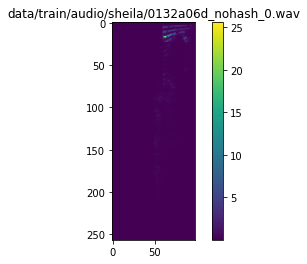

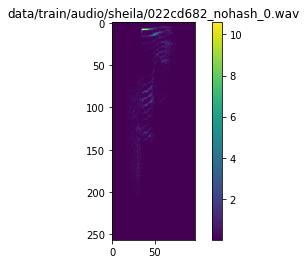

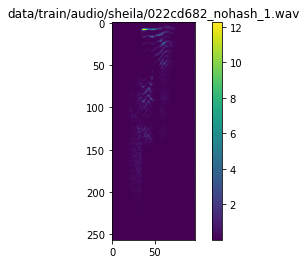

(98, 257)


In [15]:
some_spec = plot_show('sheila', output='spec')
print(some_spec.shape)

In [ ]:
some_mfcc = plot_show('stop', output='mfcc', max_disp=3)
print(some_mfcc.shape)

In [ ]:
print('Time steps: ', (16000 - 480) / 160 + 1)
print('Frequencies: ', 16000 / 160)

In [ ]:
??contrib_audio.audio_spectrogram

# Can we create a model that does the same? 

In [ ]:
num_filter = 257

input_layer = Input(shape=[16000])
x = input_layer
x = Reshape([16000, 1])(x)
x = Conv1D(num_filter, window_size_samples, strides=window_stride_samples)(x)
model = Model(input_layer, x)

def plot_show(model, label='stop'):
    fns = sorted(glob('data/train/audio/%s/*.wav' % label))
    disp_count = 0
    some_spec = None
    for fn in fns:
        if disp_count > 2:
            break
        if np.random.rand() > 0.0:
            rate, data = wf.read(fn)
            data = np.float32(data) / 32768
            data = pad_crop(data)
            spec = model.predict(data.reshape((1, -1))).squeeze()
            some_spec = spec
            print(spec.shape)
            plt.figure()
            plt.title(fn)
            plt.imshow(spec.T)
            plt.show()
            disp_count += 1
    return some_spec

In [ ]:
_ = plot_show(model)

# How about a real trained network? This one gets 94% train accuracy and 89% mean validation accuracy

In [4]:
model = load_model('checkpoints_069/ep-060-vl-0.3702.hdf5',
                 custom_objects={'relu6': relu6,
                                 'DepthwiseConv2D': DepthwiseConv2D})

In [5]:
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 16000)        0                                            
__________________________________________________________________________________________________
lambda_2 (Lambda)               (None, 16000)        0           input_1[0][0]                    
__________________________________________________________________________________________________
reshape_1 (Reshape)             (None, 16000, 1)     0           lambda_2[0][0]                   
__________________________________________________________________________________________________
conv1d_1 (Conv1D)               (None, 98, 252)      120960      reshape_1[0][0]                  
__________________________________________________________________________________________________
lambda_3 (

In [6]:
from keras.layers import Concatenate
concat_layers = [l for l in model.layers if l.__class__ == Concatenate]
print(concat_layers)

[<keras.layers.merge.Concatenate object at 0x7f84dedf2390>, <keras.layers.merge.Concatenate object at 0x7f84dedf6048>, <keras.layers.merge.Concatenate object at 0x7f84dedfd7b8>, <keras.layers.merge.Concatenate object at 0x7f84dedff630>, <keras.layers.merge.Concatenate object at 0x7f84dee06d68>, <keras.layers.merge.Concatenate object at 0x7f84dee0abe0>, <keras.layers.merge.Concatenate object at 0x7f84dee12390>, <keras.layers.merge.Concatenate object at 0x7f84ded97208>]


In [ ]:
activation = model.layers[3].output
# activation = concat_layers[0].output
spec_model = Model(model.input, activation)

In [ ]:
def norm(x):
    return (x - x.mean()) / x.std()

fns = sorted(glob('data/train/audio/go/*.wav'))
np.random.shuffle(fns)
disp_count = 0
for fn in fns:
    if disp_count > 2:
        break
    rate, data = wf.read(fn)
    data = np.float32(data) / 32768
    data = pad_crop(data)
    representation = spec_model.predict(data.reshape((1, -1))).squeeze()
    spec = load_spectrogram(fn).squeeze()
    spec, representation = norm(spec), norm(representation)
    print(spec.shape)
    plt.figure()
    plt.title(fn)
    plt.subplot(1, 2, 1)
    plt.imshow(representation.T)
    plt.subplot(1, 2, 2)
    plt.imshow(spec.T)
    plt.show()
    print(representation.shape)
    disp_count += 1
print(activation.shape)

# Looks like we succesfully decorrelated the channels. Though, it seems like this is not what we really want? There shoud be some relation between groups at least -> Use group convolutions? (g-Sub-seperable)

In [7]:
# same thing with g-Sub-seperable
model = load_model('checkpoints_071/ep-015-vl-0.4296.hdf5',
                 custom_objects={'relu6': relu6,
                                 'DepthwiseConv2D': DepthwiseConv2D})

In [8]:
from keras.layers import Concatenate
concat_layers = [l for l in model.layers if l.__class__ == Concatenate]
print(concat_layers)

[<keras.layers.merge.Concatenate object at 0x7f849fbdabe0>, <keras.layers.merge.Concatenate object at 0x7f849f798080>, <keras.layers.merge.Concatenate object at 0x7f849f79e6d8>, <keras.layers.merge.Concatenate object at 0x7f849f7a5f28>, <keras.layers.merge.Concatenate object at 0x7f849f7ad9b0>, <keras.layers.merge.Concatenate object at 0x7f849f7b2e10>, <keras.layers.merge.Concatenate object at 0x7f849f7bb748>, <keras.layers.merge.Concatenate object at 0x7f849f640c88>]


In [12]:
activation = model.layers[3].output
# activation = concat_layers[0].output
spec_model = Model(model.input, activation)

(98, 257)


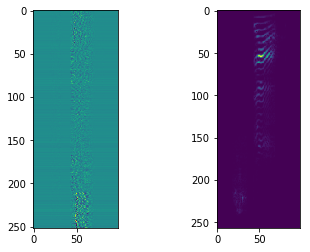

(98, 252)
(98, 257)


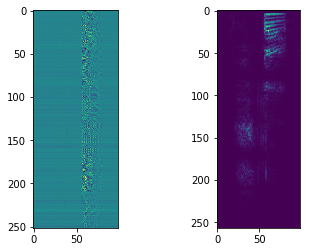

(98, 252)
(98, 257)


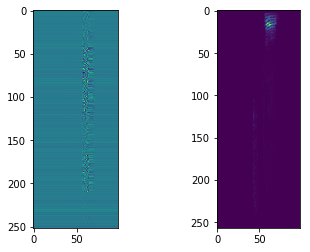

(98, 252)


In [13]:
def norm(x):
    return (x - x.mean()) / x.std()

fns = sorted(glob('data/train/audio/stop/*.wav'))
np.random.shuffle(fns)
disp_count = 0
for fn in fns:
    if disp_count > 2:
        break
    rate, data = wf.read(fn)
    data = np.float32(data) / 32768
    data = pad_crop(data)
    representation = spec_model.predict(data.reshape((1, -1))).squeeze()
    spec = load_spectrogram(fn).squeeze()
    spec, representation = norm(spec), norm(representation)
    print(spec.shape)
    plt.figure()
    plt.title(fn)
    plt.subplot(1, 2, 1)
    plt.imshow(np.flipud(representation.T))
    plt.subplot(1, 2, 2)
    plt.imshow(spec.T)
    plt.show()
    print(representation.shape)
    disp_count += 1
# print(activation.shape)

# Some basic fft stuff

In [ ]:
dt = 40e-9
t = np.arange(0, 1e-6, dt)
fscale = t / max(t)
y = np.cos(2 * pi * 1e6 * t*fscale) + (np.cos(2 * pi * 2e6 *t*fscale) * np.cos(2 * pi * 2e6 * t*fscale))
y *= np.hanning(len(y))
yy = np.concatenate((y, ([0] * 10 * len(y))))